In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras import Sequential, layers, utils, losses
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import warnings
warnings.filterwarnings('ignore')


In [3]:
import  tensorflow as tf
tf.__version__

'2.13.0'

第一步：数据集的加载和了解

In [4]:
#加载数据
dataset = pd.read_csv("london_merged.csv")

In [4]:
dataset.dtypes

timestamp        object
cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

In [5]:
# 将timestamp做一个时间类型的转换
dataset["timestamp"] = pd.to_datetime(dataset["timestamp"])


In [6]:
dataset.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

In [6]:
dataset = dataset.set_index("timestamp")

In [7]:
#数据集大小 共17414行,每行9个字段(第一个timestamp作为了索引，所以不是10个，后面要切分)
dataset.shape

(17414, 9)

In [8]:
#显示数据集前五行（默认）
dataset.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [9]:
#显示数据集后五行（默认）
dataset.tail()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0
2017-01-03 23:00:00,139,5.0,1.0,76.0,22.0,2.0,0.0,0.0,3.0


这里解释一下各个字段含义：
timestamp：时间戳

cnt：单车使用数量（即目标）

t1：气温

t2：体感温度

hum：湿度

wind_speed：风速

weather_code：天气类别category 1=干净 2=很少的云 3=碎云 4=多云 7=小雨/雨 10=有雷雨 26=降雪 94=冰雾

is_holiday：是否为假期，1-假期，0-非假期

is_weekend：是否为周末，如果一天是周末，则为1

season：季节 0-春季；1-夏；2-秋；3-冬

In [10]:
#数据集信息  条数 有无空置 类型  看看数据大概要不要预处理
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnt           17414 non-null  int64  
 1   t1            17414 non-null  float64
 2   t2            17414 non-null  float64
 3   hum           17414 non-null  float64
 4   wind_speed    17414 non-null  float64
 5   weather_code  17414 non-null  float64
 6   is_holiday    17414 non-null  float64
 7   is_weekend    17414 non-null  float64
 8   season        17414 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.3 MB


In [11]:
#数据集描述 数量 均值 标准差 最小值 下四分位数  中位数 上四分位数 最大值
dataset.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


第二步：进行数据集可视化

In [8]:
#相关系数绝对值
corr_matrix = dataset.corr().abs()
corr_matrix

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
cnt,1.000000,0.388798,0.369035,0.462901,0.116295,0.166633,0.051698,0.096499,0.116180
t1,0.388798,1.000000,0.988344,0.447781,0.145471,0.097114,0.042233,0.005342,0.285851
t2,0.369035,0.988344,1.000000,0.403495,0.088409,0.098385,0.040051,0.008510,0.285900
hum,0.462901,0.447781,0.403495,1.000000,0.287789,0.334750,0.032068,0.028098,0.290381
wind_speed,0.116295,0.145471,0.088409,0.287789,1.000000,0.124803,0.002606,0.011479,0.010305
weather_code,0.166633,0.097114,0.098385,0.334750,0.124803,1.000000,0.012939,0.042362,0.098976
is_holiday,0.051698,0.042233,0.040051,0.032068,0.002606,0.012939,1.000000,0.094898,0.032488
is_weekend,0.096499,0.005342,0.008510,0.028098,0.011479,0.042362,0.094898,1.000000,0.001067
season,0.116180,0.285851,0.285900,0.290381,0.010305,0.098976,0.032488,0.001067,1.000000


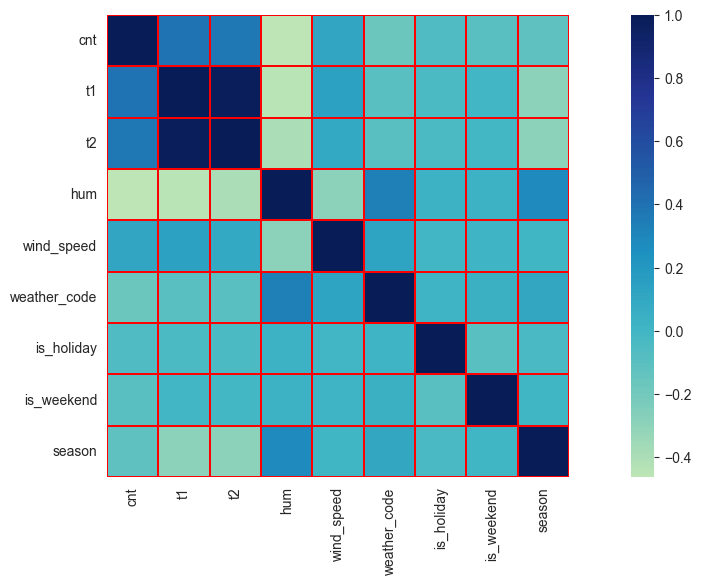

In [13]:
#热力图
plt.figure(figsize=(16,6))

sns.heatmap(dataset.corr(),
            cmap="YlGnBu",  # 色系
            square=True,  # 方形
            linewidths=.2,
            center=0,
            linecolor="red"  # 线条颜色
           )

plt.show()

(array([16436., 16526., 16617., 16709., 16801., 16892., 16983., 17075.,
        17167.]),
 [Text(16436.0, 0, '2015-01'),
  Text(16526.0, 0, '2015-04'),
  Text(16617.0, 0, '2015-07'),
  Text(16709.0, 0, '2015-10'),
  Text(16801.0, 0, '2016-01'),
  Text(16892.0, 0, '2016-04'),
  Text(16983.0, 0, '2016-07'),
  Text(17075.0, 0, '2016-10'),
  Text(17167.0, 0, '2017-01')])

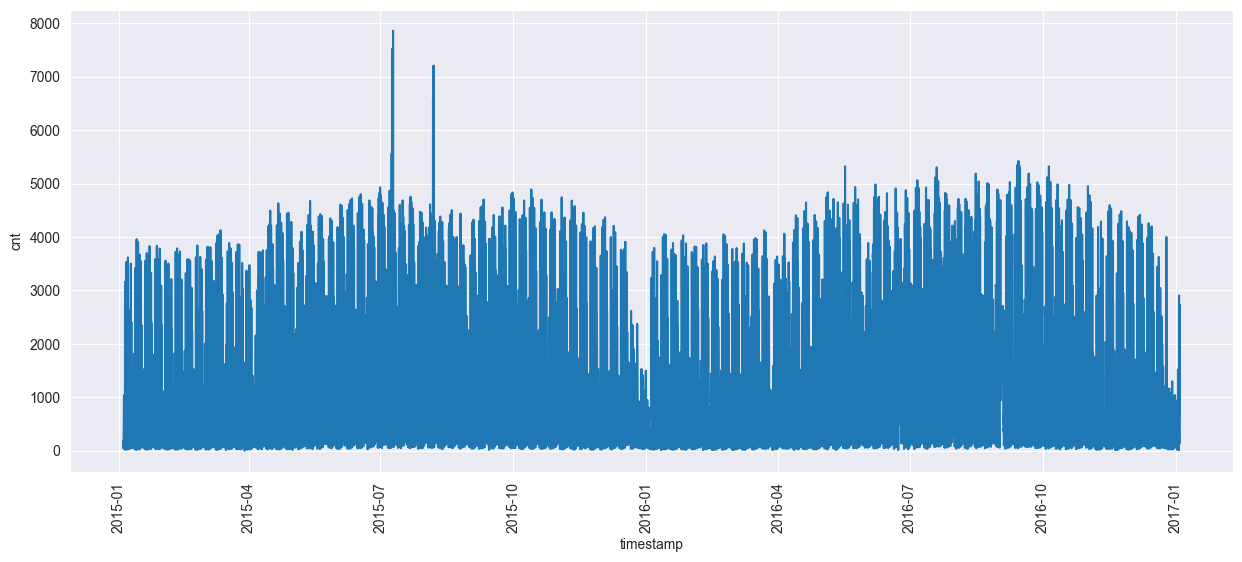

In [14]:
#整体的需求量cnt随着时间变化的关系
plt.figure(figsize=(15,6))

sns.lineplot(data=dataset,  # 传入数据
             x=dataset.index,  # 时间
             y=dataset.cnt  # 需求量
            )

plt.xticks(rotation=90)

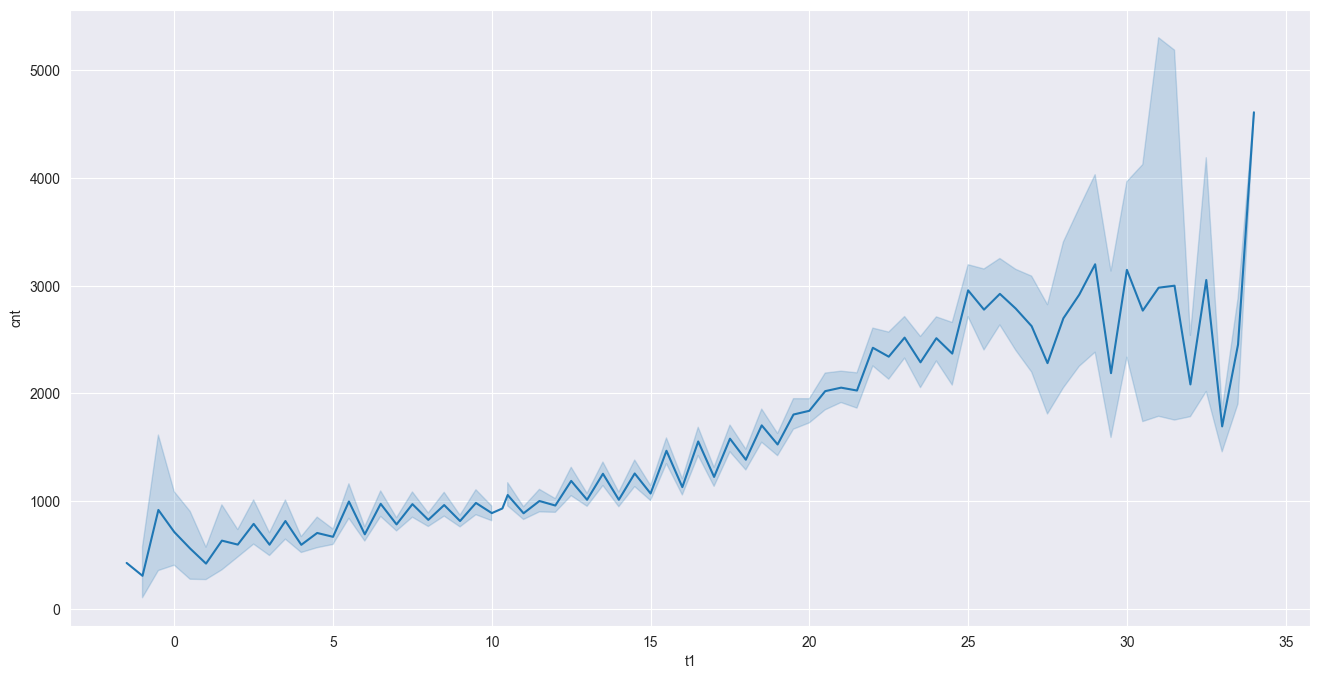

In [15]:
# 字段t1(气温)与字段cnt(单车使用量)之间的关系
plt.figure(figsize=(16,8))
sns.lineplot(x='t1', y='cnt', data=dataset)
plt.show()

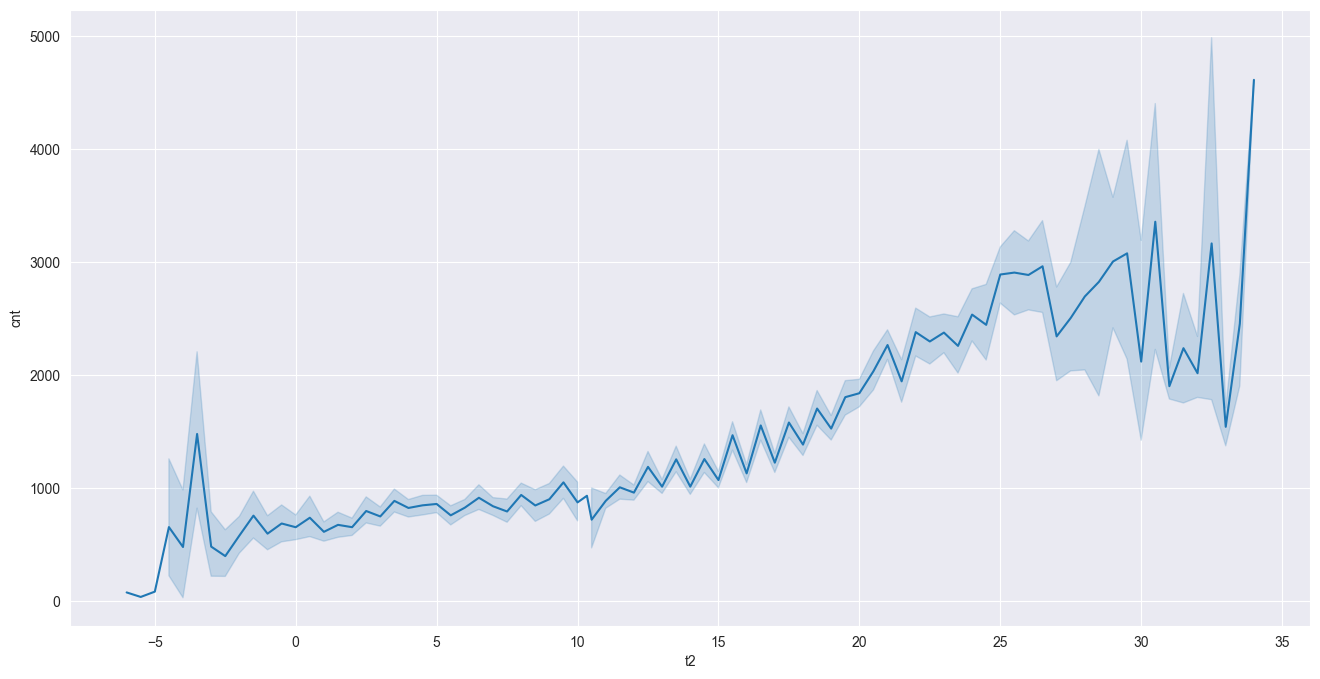

In [16]:
# 字段t2(体感温度)与字段cnt(单车使用量)之间的关系
plt.figure(figsize=(16,8))
sns.lineplot(x='t2', y='cnt', data=dataset)
plt.show()

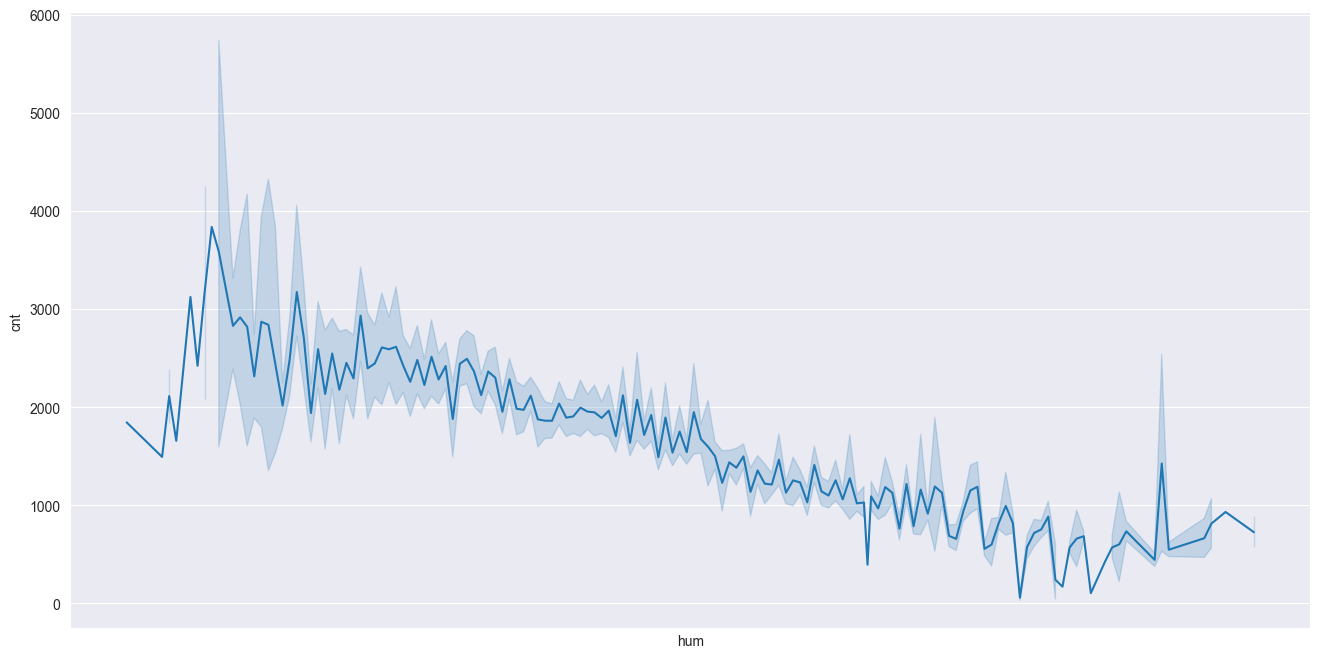

In [17]:
# 字段hum(湿度)与字段cnt(单车使用量)之间的关系
plt.figure(figsize=(16,8))
sns.lineplot(x='hum', y='cnt', data=dataset)
plt.xticks([])
plt.show()

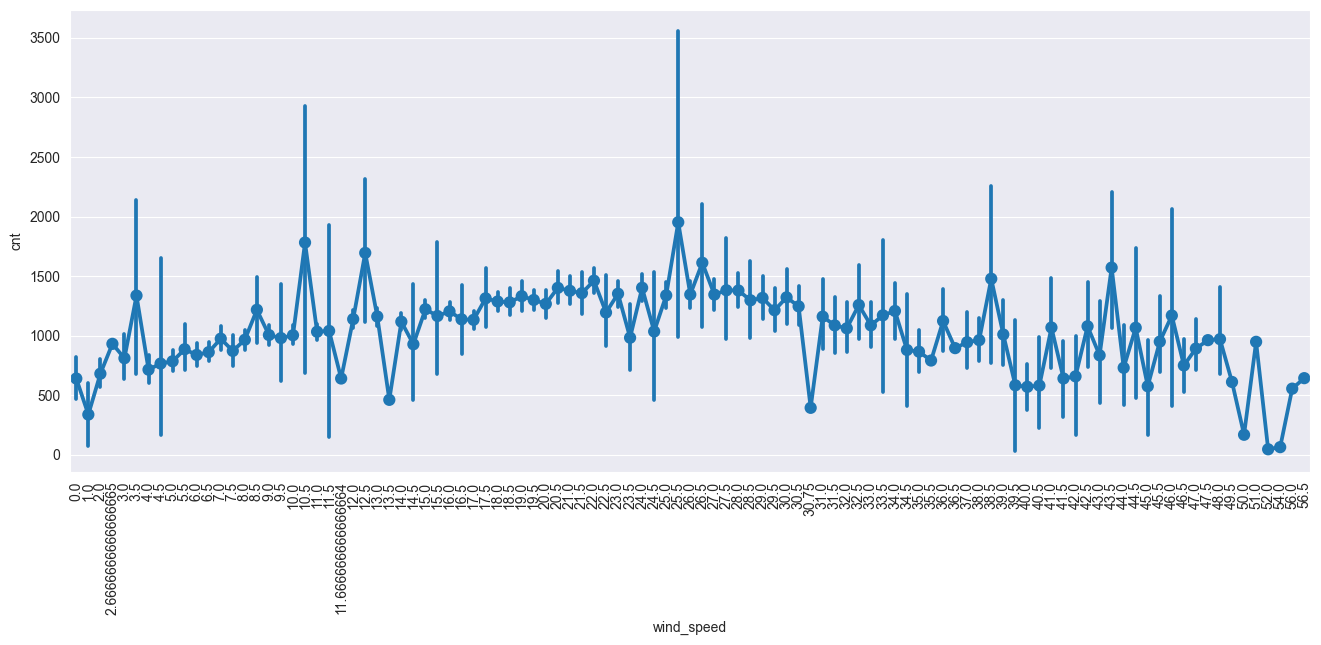

In [18]:
#风度与字段cnt（单车使用量）之间的关系
plt.figure(figsize=(16,6))

sns.pointplot(data=dataset,
              x=dataset.wind_speed,
              y=dataset.cnt)

plt.xticks(rotation=90)

plt.show()

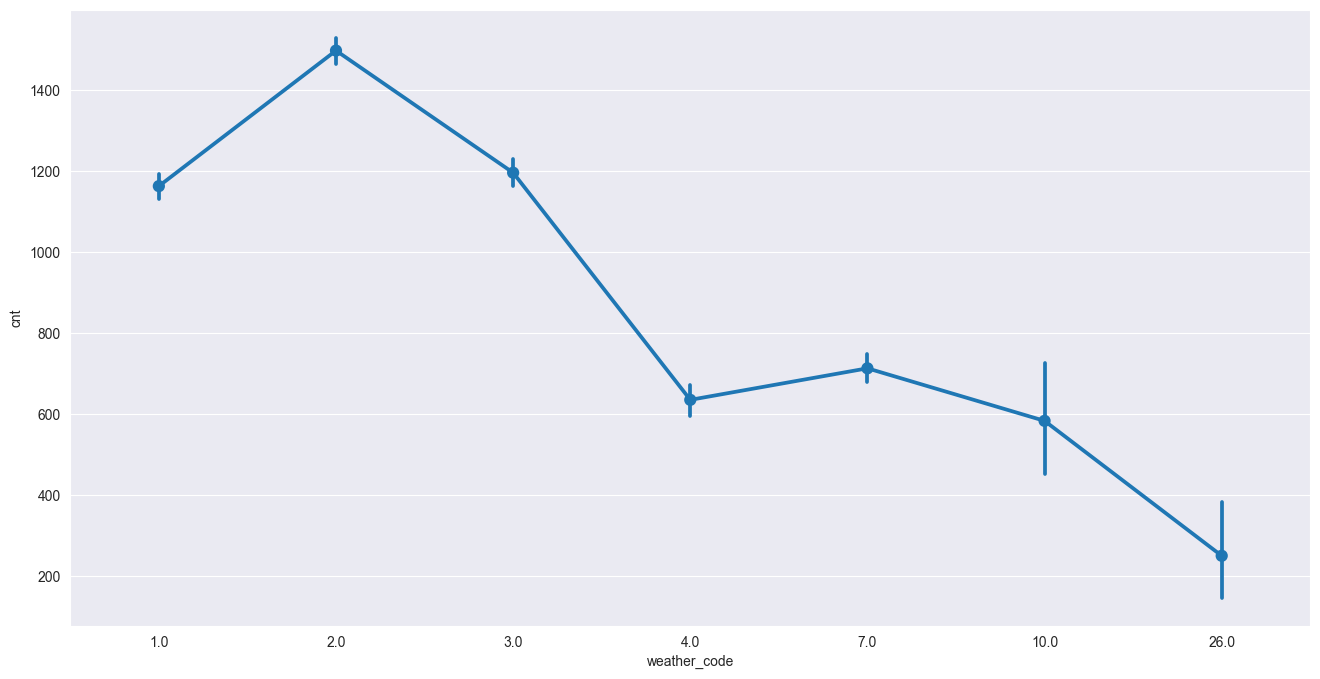

In [19]:
#天气类别与字段cnt（单车使用量）之间的关系
#1=干净 2=很少的云 3=碎云 4=多云 7=小雨/雨 10=有雷雨 26=降雪 94=冰雾(下图种没有94说明数据里就没94)
plt.figure(figsize=(16,8))
sns.pointplot(x='weather_code', y='cnt', data=dataset)
plt.show()

下面创建几个字段，如用来分析一天的时间（每个小时）的单车用量

In [7]:
#创建hour字段
dataset["hour"] = dataset.index.hour

In [8]:
#创建year字段
dataset["year"] = dataset.index.year

In [9]:
#创建month字段
dataset["month"] = dataset.index.month

In [23]:
#再次显示数据集
dataset.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,year,month
timestamp,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,2015,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,2015,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,2015,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,2015,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,2015,1


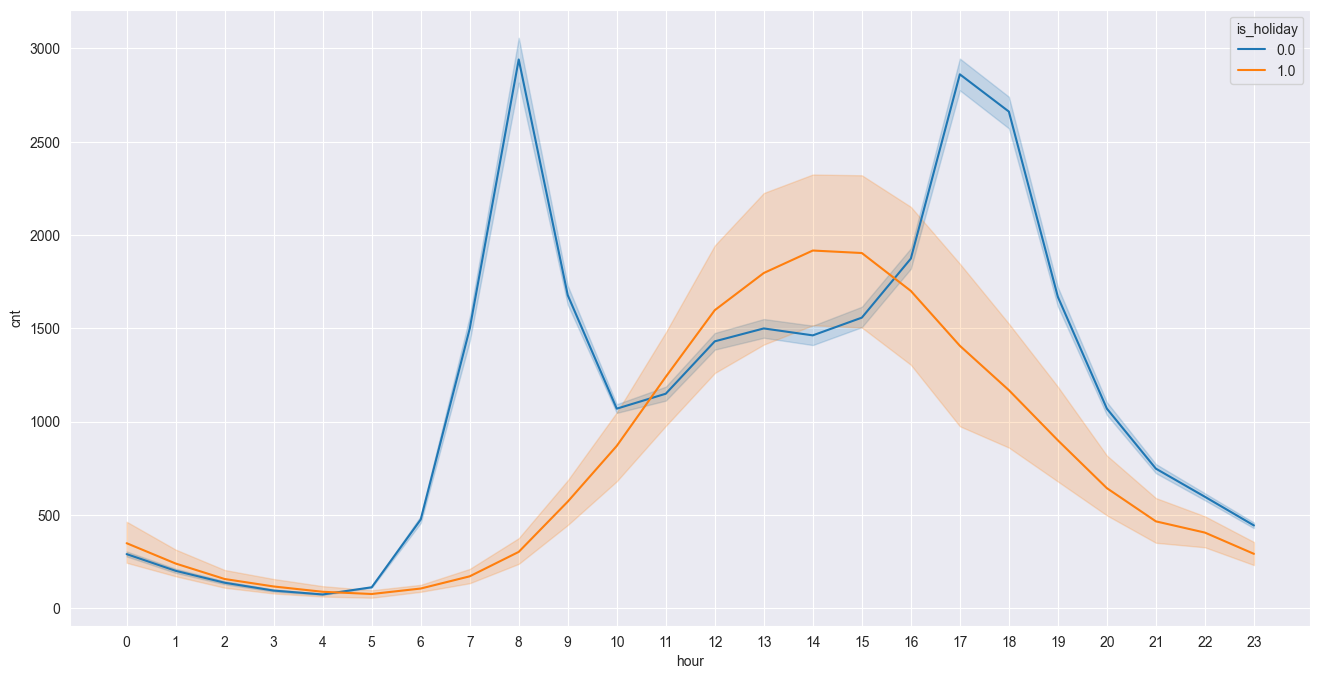

In [24]:
#基于是否是假期统计hour和cnt之间的分布    是否为假期，1-假期，0-非假期
plt.figure(figsize=(16,8))
sns.lineplot(x='hour',y='cnt',data=dataset,hue='is_holiday')
plt.xticks(list(range(24)))
plt.show()

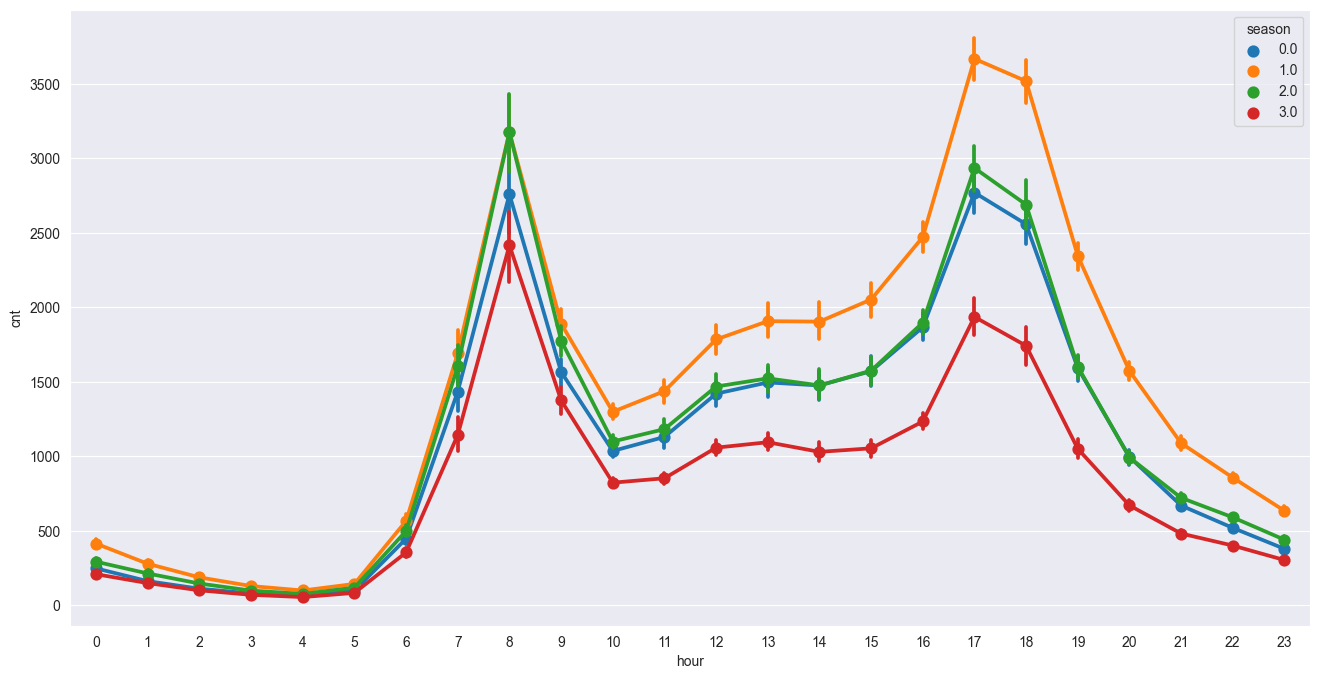

In [25]:
#基于season统计hour与cnt之间的分布 0春天1夏天2秋天3冬天
plt.figure(figsize=(16,8))
sns.pointplot(x='hour',y='cnt',data=dataset,hue='season')
plt.xticks(list(range(24)))
plt.show()

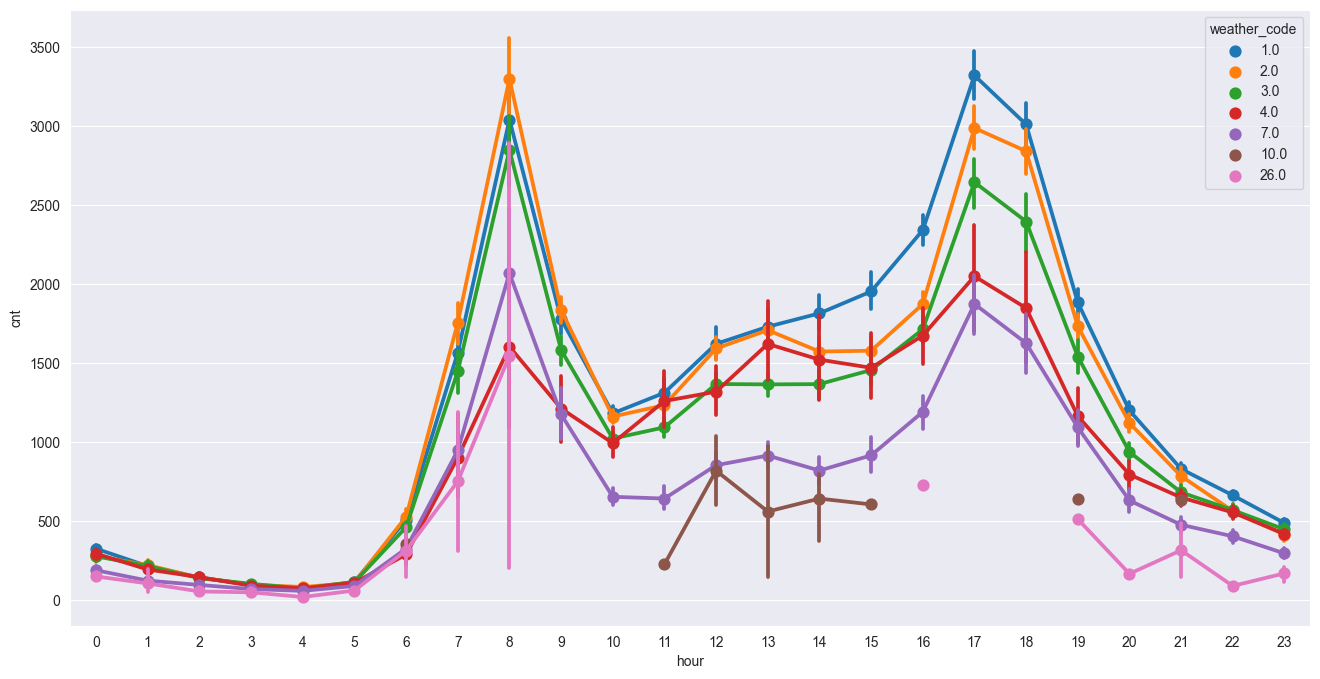

In [26]:
#基于weather_code统计hour与cnt之间的分布 0春天1夏天2秋天3冬天
plt.figure(figsize=(16,8))
sns.pointplot(x='hour',y='cnt',data=dataset,hue='weather_code')
plt.xticks(list(range(24)))
plt.show()

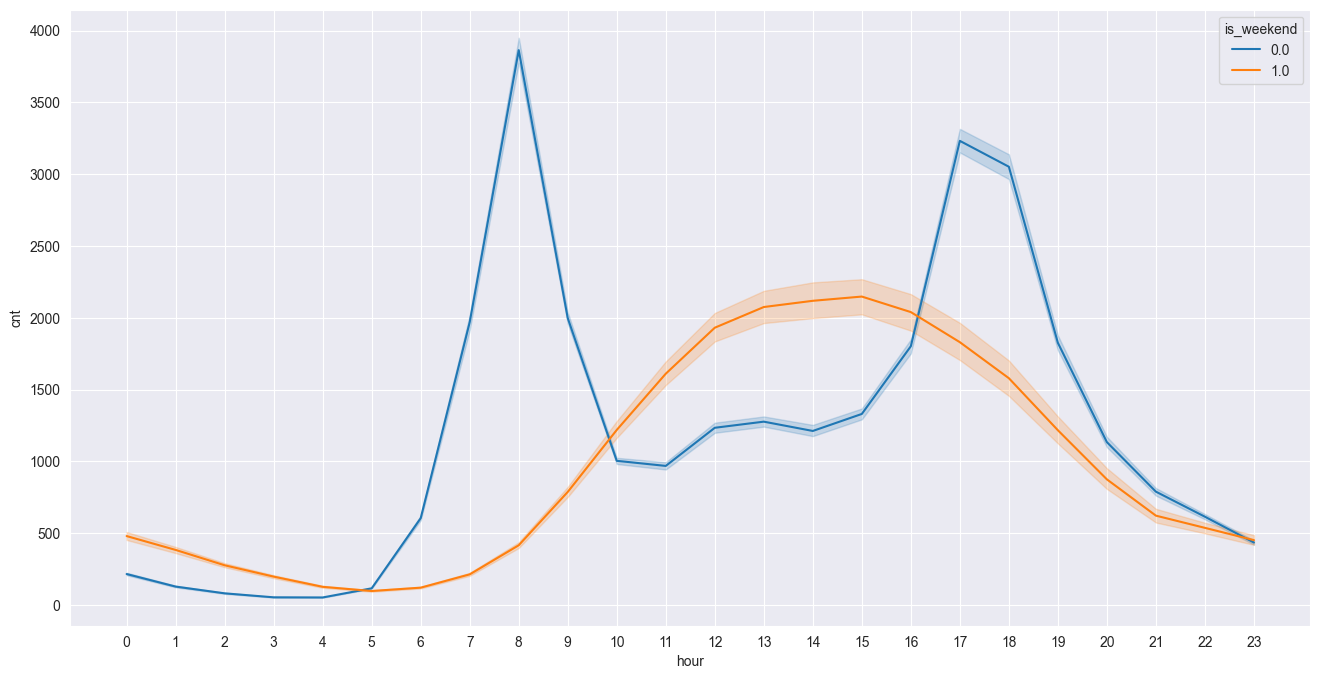

In [27]:
#基于是否是周末统计hour和cnt之间的分布    是否为假期，1-周末，0-不是
plt.figure(figsize=(16,8))
sns.lineplot(x='hour',y='cnt',data=dataset,hue='is_weekend')
plt.xticks(list(range(24)))
plt.show()

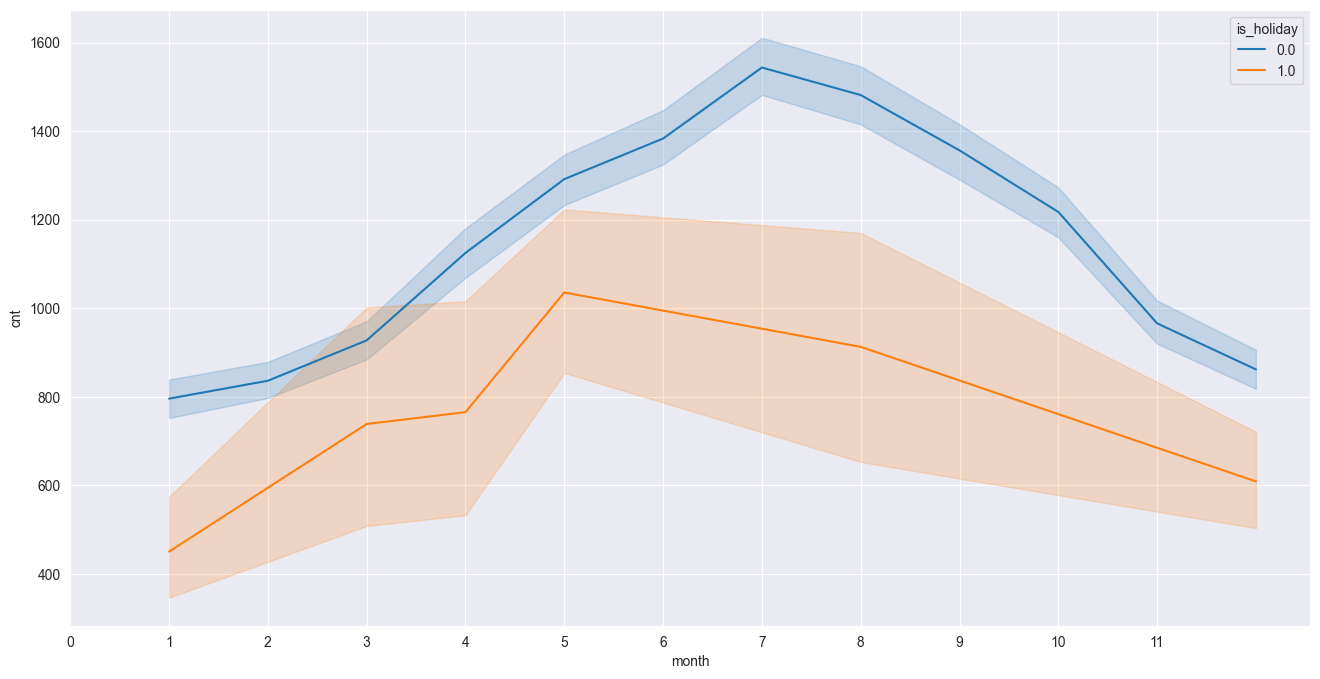

In [28]:
#基于是否是假期统计month和cnt之间的分布    是否为假期，1-假期，0-非假期
plt.figure(figsize=(16,8))
sns.lineplot(x='month',y='cnt',data=dataset,hue='is_holiday')
plt.xticks(list(range(12)))
plt.show()

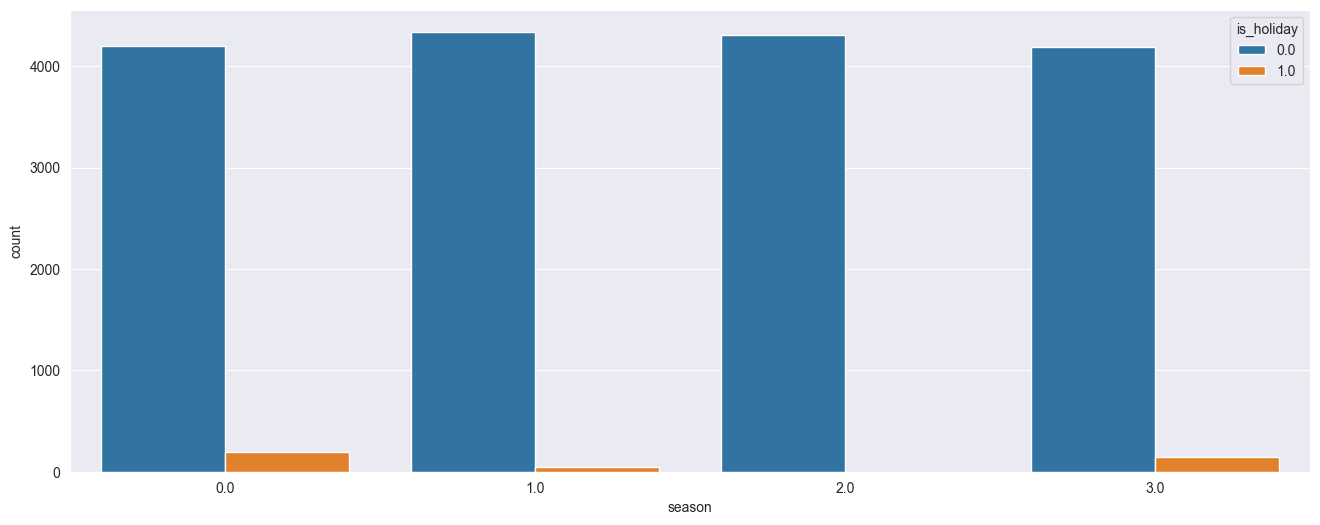

In [29]:
#季度+是否节假日
plt.figure(figsize=(16,6))

# 分组统计数量
sns.countplot(data=dataset,
              x=dataset.season,
              hue=dataset.is_holiday,
             )

plt.show()

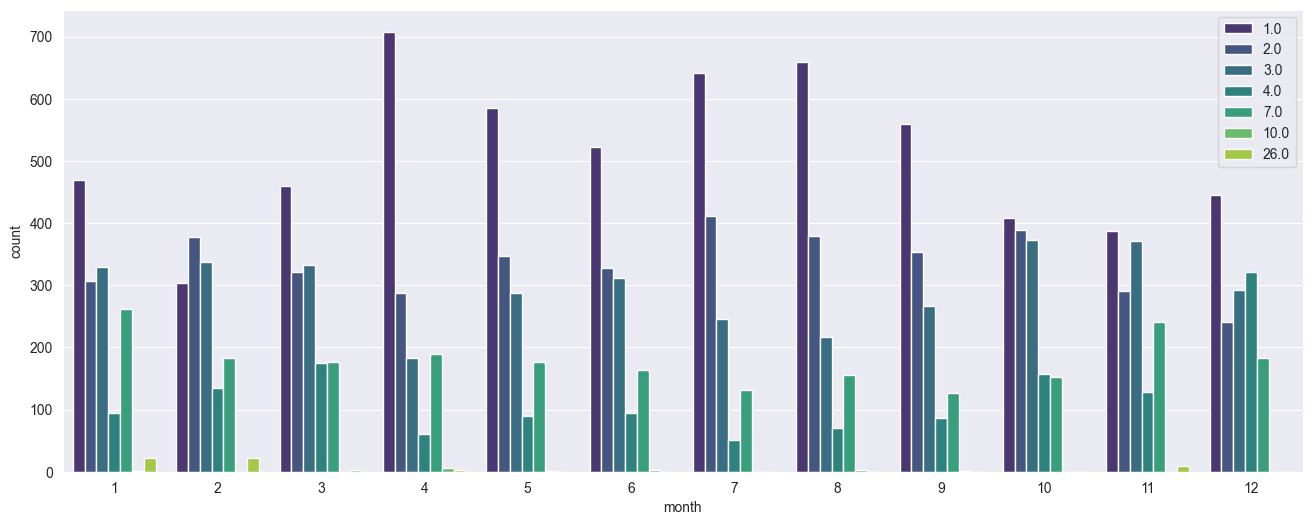

In [30]:
#月+天气情况
plt.figure(figsize=(16,6))

sns.countplot(
    data=dataset,
    x=dataset.month,  # 一周中的第几天
    hue=dataset.weather_code,  # 天气情况
    palette="viridis")

plt.legend(loc="best")  # 位置选择

plt.show()

1.可以做任意相关数据的分析2.发现所得图像据符合常理

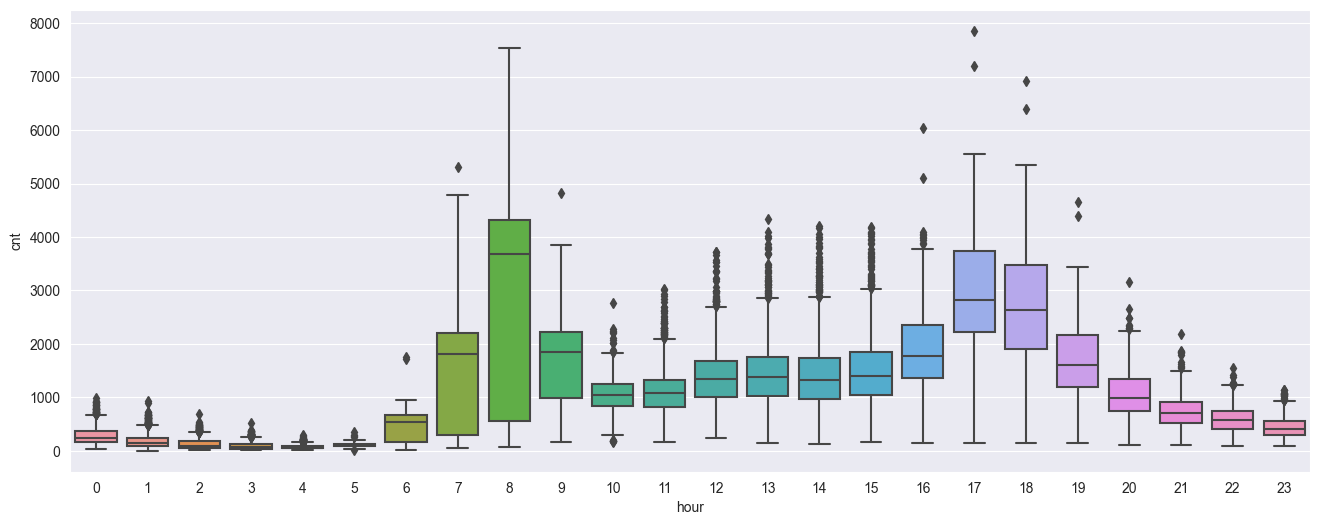

In [31]:
#箱型图能够反映一组数据的分布情况
#按小时
plt.figure(figsize=(16,6))

sns.boxplot(data=dataset,
            x=dataset.hour,  # 小时
            y=dataset.cnt)

plt.show()

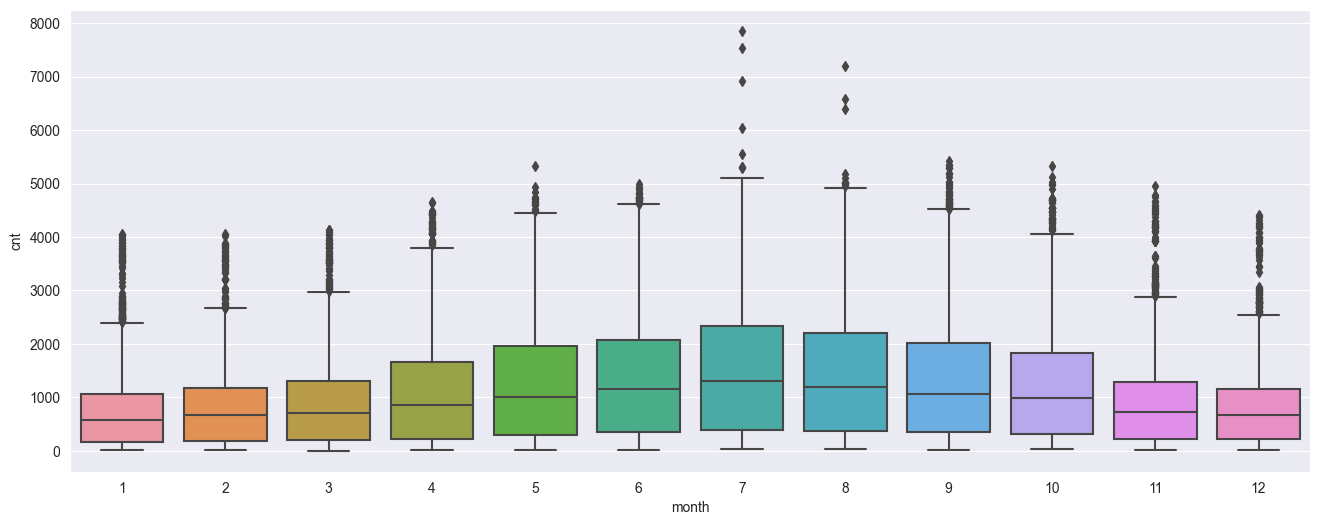

In [32]:
#按月
plt.figure(figsize=(16,6))

sns.boxplot(data=dataset,
            x=dataset["month"],
            y=dataset.cnt)

plt.show()

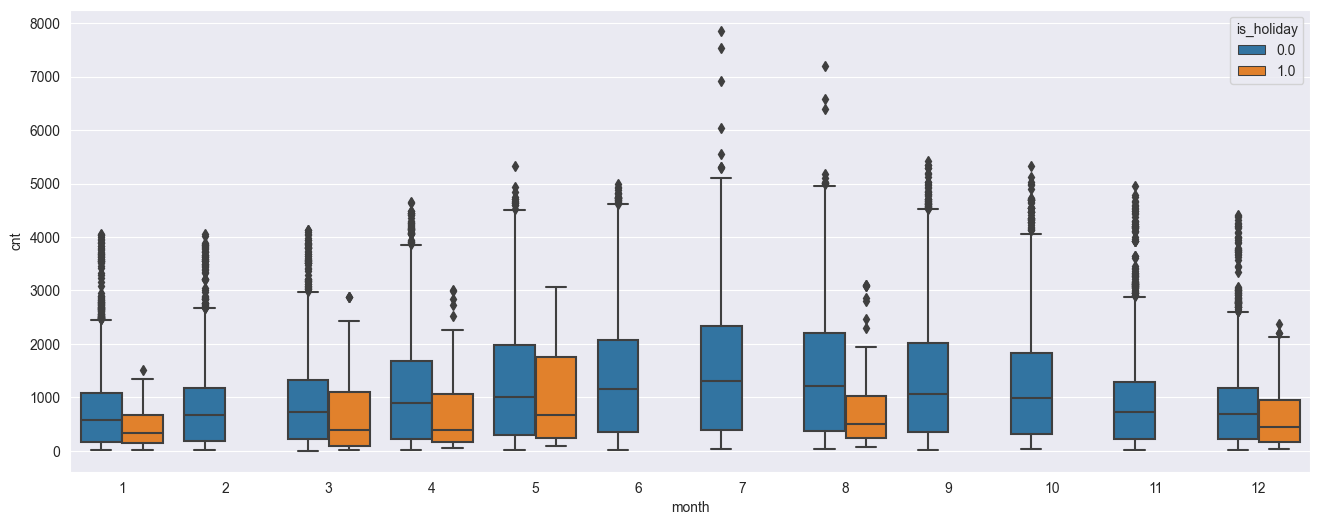

In [33]:
# 每月和是否节假日统计

plt.figure(figsize=(16,6))

sns.boxplot(
    data=dataset,
    x=dataset["month"],
    y=dataset.cnt,
    hue=dataset["is_holiday"])

plt.show()

第三步：数据预处理

In [10]:
#删除多余的列hour，year，month
dataset.drop(columns=['year','month'],axis=1,inplace=True)

In [35]:
dataset.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour
timestamp,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4


这里解释下：
cnt：是标签（预测值）
t1,t2,hum,wind_speed:是数值类型字段
weather_code,is_holiday,is_weekend,season：是分类类型字段
我们归一化只对前面5个归一，因为后面的分类字段的值很小，影响不大

In [11]:
#对前面字段归一化
columns = ['cnt','t1','t2','hum','wind_speed','hour']
for col in columns:
    scaler = MinMaxScaler()
    dataset[col] = scaler.fit_transform(dataset[col].values.reshape(-1,1))

In [37]:
#归一化结果
dataset.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour
timestamp,,,,,,,,,,
2015-01-04 00:00:00,0.023155,0.126761,0.2000,0.911950,0.106195,3.0,0.0,1.0,3.0,0.000000
2015-01-04 01:00:00,0.017557,0.126761,0.2125,0.911950,0.088496,1.0,0.0,1.0,3.0,0.043478
2015-01-04 02:00:00,0.017048,0.112676,0.2125,0.955975,0.000000,1.0,0.0,1.0,3.0,0.086957
2015-01-04 03:00:00,0.009160,0.098592,0.2000,1.000000,0.000000,1.0,0.0,1.0,3.0,0.130435
2015-01-04 04:00:00,0.005980,0.098592,0.1500,0.911950,0.115044,1.0,0.0,1.0,3.0,0.173913


第四步：特种工程

In [12]:
#特征数据集
X = dataset.drop(columns=['cnt'],axis=1)
#标签数据集
y = dataset['cnt']

In [39]:
X.shape

(17414, 9)

In [40]:
y.shape

(17414,)

In [13]:
#数据集分离：X_train, X_test 测试集战20 shuffle保证不打乱
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False,random_state=666)

In [42]:
X_train.shape

(13931, 9)

In [43]:
y_train.shape

(13931,)

In [44]:
X_train.head()

,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour
timestamp,,,,,,,,,
2015-01-04 00:00:00,0.126761,0.2000,0.911950,0.106195,3.0,0.0,1.0,3.0,0.000000
2015-01-04 01:00:00,0.126761,0.2125,0.911950,0.088496,1.0,0.0,1.0,3.0,0.043478
2015-01-04 02:00:00,0.112676,0.2125,0.955975,0.000000,1.0,0.0,1.0,3.0,0.086957
2015-01-04 03:00:00,0.098592,0.2000,1.000000,0.000000,1.0,0.0,1.0,3.0,0.130435
2015-01-04 04:00:00,0.098592,0.1500,0.911950,0.115044,1.0,0.0,1.0,3.0,0.173913


In [45]:
X_test.shape

(3483, 9)

In [46]:
y_test.shape

(3483,)

In [47]:
X_test.head()

,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour
timestamp,,,,,,,,,
2016-08-10 03:00:00,0.408451,0.4750,0.710692,0.283186,1.0,0.0,0.0,1.0,0.130435
2016-08-10 04:00:00,0.408451,0.4750,0.710692,0.247788,1.0,0.0,0.0,1.0,0.173913
2016-08-10 05:00:00,0.394366,0.4625,0.742138,0.230088,1.0,0.0,0.0,1.0,0.217391
2016-08-10 06:00:00,0.408451,0.4750,0.742138,0.265487,1.0,0.0,0.0,1.0,0.260870
2016-08-10 07:00:00,0.422535,0.4875,0.679245,0.283186,2.0,0.0,0.0,1.0,0.304348


In [14]:
def create_dataset(X, y, seq_len=1): #步长为10
    features = []
    targets = []

    for i in range(0, len(X)-1 , 1):
        data = X.iloc[i:i+seq_len] # 序列数据  利用'iloc'函数,取行
        label = y.iloc[i+seq_len] # 标签数据
        # 保存到features和labels
        features.append(data)
        targets.append(label)

    # 返回
    return np.array(features), np.array(targets)

In [15]:
# ① 构造训练特征数据集
train_dataset, train_labels = create_dataset(X_train, y_train, seq_len=1)

In [50]:
train_dataset.shape #下面输出表示有13921调划窗，每个划窗有10条数据，每条数据有9个特征

(13930, 1, 9)

In [51]:
train_labels.shape #每个窗口对应一个标签

(13930,)

In [17]:
# ② 构造测试特征数据集
test_dataset, test_labels = create_dataset(X_test, y_test, seq_len=1)

In [53]:
test_dataset.shape

(3482, 1, 9)

In [54]:
test_labels.shape

(3482,)

In [18]:
# 3 构造批数据 #这里可以打乱窗口数据，但是窗口间数据是没打乱的
def create_batch_dataset(X, y, train=True, buffer_size=1000, batch_size=128):
    batch_data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # 数据封装，tensor类型
    if train: # 训练集
        return batch_data.cache().shuffle(buffer_size).batch(batch_size)
    else: # 测试集
        return batch_data.batch(batch_size)

In [19]:
# 训练批数据
train_batch_dataset = create_batch_dataset(train_dataset, train_labels)

In [20]:
# 测试批数据
test_batch_dataset = create_batch_dataset(test_dataset, test_labels, train=False)

In [58]:
#从测试批数据中，获取一个batch_size的样本数据 第一批数据
list(test_batch_dataset.as_numpy_iterator())[0]

(array([[[0.4084507 , 0.475     , 0.71069182, ..., 0.        ,
          1.        , 0.13043478]],
 
        [[0.4084507 , 0.475     , 0.71069182, ..., 0.        ,
          1.        , 0.17391304]],
 
        [[0.3943662 , 0.4625    , 0.74213836, ..., 0.        ,
          1.        , 0.2173913 ]],
 
        ...,
 
        [[0.53521127, 0.5875    , 0.54716981, ..., 0.        ,
          1.        , 0.34782609]],
 
        [[0.57746479, 0.625     , 0.44654088, ..., 0.        ,
          1.        , 0.39130435]],
 
        [[0.5915493 , 0.6375    , 0.47169811, ..., 0.        ,
          1.        , 0.43478261]]]),
 array([0.00648855, 0.01832061, 0.106743  , 0.30050891, 0.56526718,
        0.28371501, 0.15572519, 0.15585242, 0.19211196, 0.20152672,
        0.20381679, 0.22430025, 0.31704835, 0.57315522, 0.55712468,
        0.38129771, 0.23880407, 0.14987277, 0.1173028 , 0.0735369 ,
        0.03740458, 0.02290076, 0.01463104, 0.01170483, 0.00954198,
        0.01437659, 0.09389313, 0.28956

第五步：模型搭建、编译、训练

In [21]:
# 模型搭建--版本1
model = Sequential([
    layers.LSTM(units=256, input_shape=(1,9), return_sequences=True),# 这里input_shape可以直接写(10,8)
    layers.Dropout(0.4), #舍去一部分神经元，保留一部分，符合LSTM定义
    layers.LSTM(units=256, return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(units=128, return_sequences=True),
    layers.LSTM(units=32),
    layers.Dense(1)
])


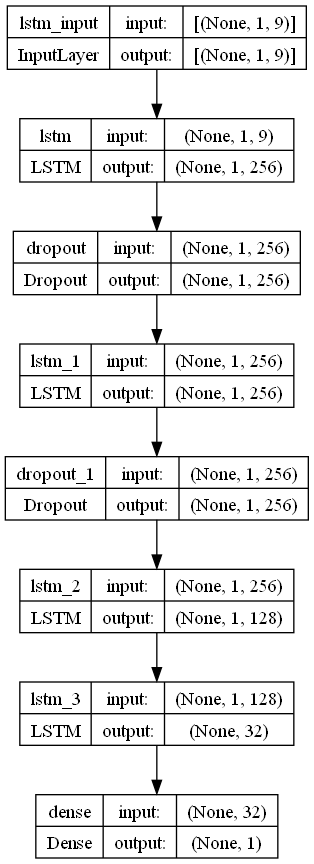

In [16]:
#显示模型结构,他就是不显示。。。
from keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True)

In [22]:
# 模型编译
model.compile(optimizer='adam',loss='mse')


In [23]:
#用于保存最好的模型
checkpoint_file = "best_model.hdf5" #实际报错了，可以改为.ckpt
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_file,
                                      monitor='loss',
                                      mode='min',
                                      save_best_only=True,
                                      save_weights_only=True)


In [24]:
# 模型训练 callba保存一个最好模型
history = model.fit(train_batch_dataset,
                    epochs=30,
                    validation_data=test_batch_dataset,
                    callbacks=[checkpoint_callback])


Epoch 1/30
109/109 [==============================] - 8s 26ms/step - loss: 0.0174 - val_loss: 0.0172
Epoch 2/30
109/109 [==============================] - 2s 17ms/step - loss: 0.0148 - val_loss: 0.0177
Epoch 3/30
109/109 [==============================] - 2s 17ms/step - loss: 0.0141 - val_loss: 0.0180
Epoch 4/30
109/109 [==============================] - 2s 17ms/step - loss: 0.0140 - val_loss: 0.0160
Epoch 5/30
109/109 [==============================] - 2s 17ms/step - loss: 0.0136 - val_loss: 0.0164
Epoch 6/30
109/109 [==============================] - 2s 17ms/step - loss: 0.0133 - val_loss: 0.0159
Epoch 7/30
109/109 [==============================] - 2s 17ms/step - loss: 0.0131 - val_loss: 0.0156
Epoch 8/30
109/109 [==============================] - 2s 17ms/step - loss: 0.0129 - val_loss: 0.0150
Epoch 9/30
109/109 [==============================] - 2s 17ms/step - loss: 0.0122 - val_loss: 0.0125
Epoch 10/30
109/109 [==============================] - 2s 17ms/step - loss: 0.0107 - val_lo

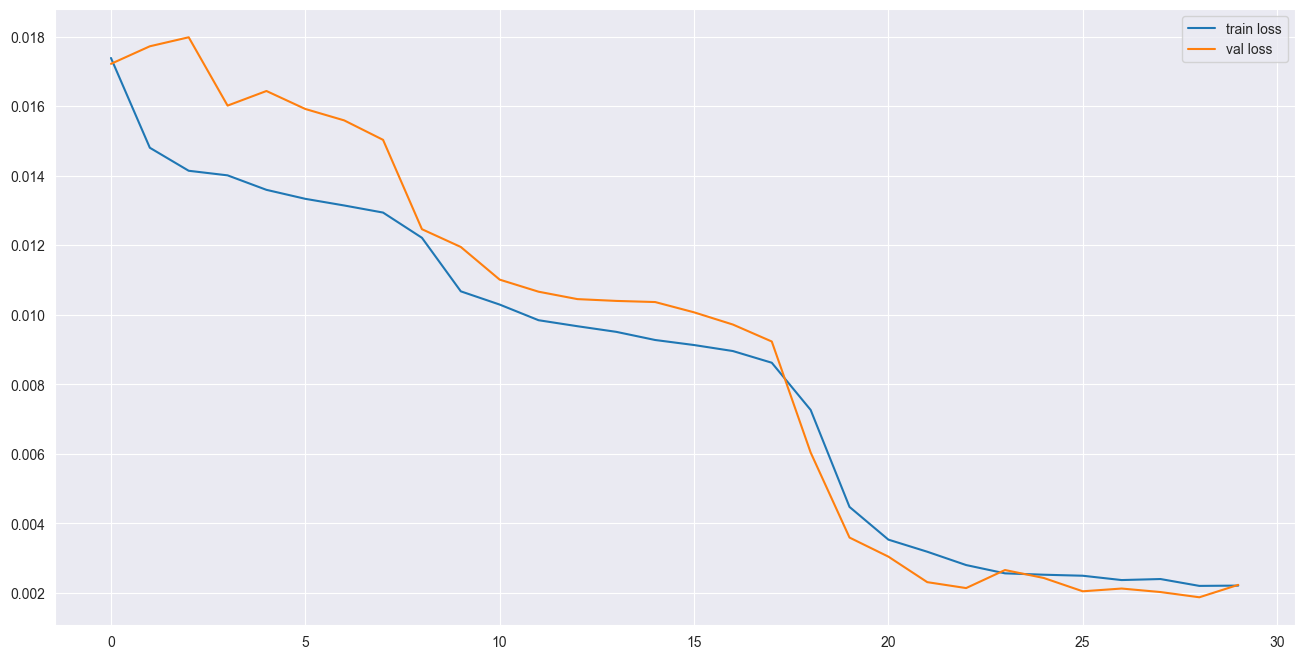

In [25]:
# 显示训练结果
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(loc='best')
plt.show()


第六步：模型的验证

In [26]:
test_dataset.shape #这里先看了一下测试集大小

(3482, 1, 9)

In [27]:
test_preds = model.predict(test_dataset,verbose =1) #这里跑了一下测试集

109/109 [==============================] - 2s 3ms/step


In [14]:
test_preds.shape#测试的结果格式

(24, 1)

In [28]:
test_preds[:10]

array([[0.0255527 ],
       [0.04534228],
       [0.13852811],
       [0.3287385 ],
       [0.5121064 ],
       [0.2098245 ],
       [0.1559613 ],
       [0.15793699],
       [0.17694716],
       [0.17990957]], dtype=float32)

In [29]:
test_preds = test_preds[:, 0] # 获取列值
test_preds[:10]

array([0.0255527 , 0.04534228, 0.13852811, 0.3287385 , 0.5121064 ,
       0.2098245 , 0.1559613 , 0.15793699, 0.17694716, 0.17990957],
      dtype=float32)

In [71]:
test_labels.shape

(3482,)

In [30]:
# 计算r2值
score = r2_score(test_labels, test_preds)
print("r^2 值为： ", score)

r^2 值为：  0.89157366013723


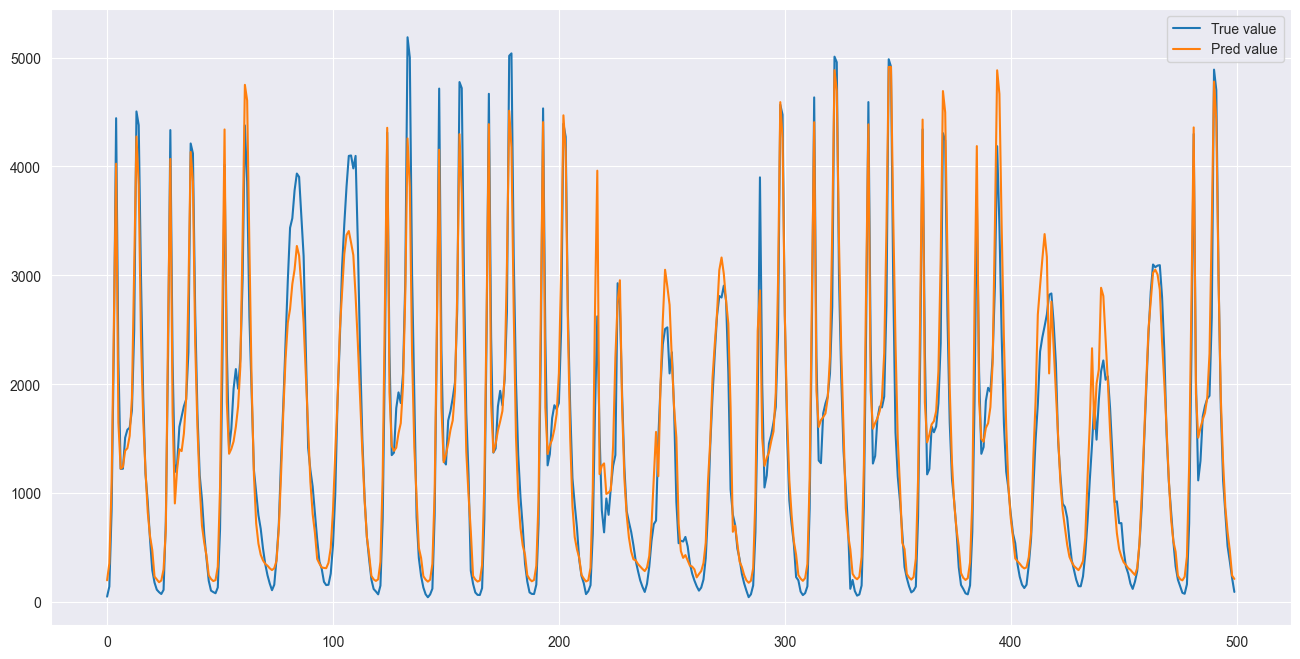

In [32]:
# 绘制 预测与真值结果
max_val=7860
min_val=0
test_labels_1 = np.array(test_labels) * (max_val - min_val) + min_val
test_preds_1 = np.array(test_preds) * (max_val - min_val) + min_val
#scaler = MinMaxScaler(feature_range=(min_value, max_value))
# scaler.fit(test_labels.reshape(-1, 1))
# test_labels_1 = scaler.inverse_transform(test_labels.reshape(-1, 1))
# test_preds_1 = scaler.inverse_transform(test_preds.reshape(-1, 1))

# test_labels_1 = scaler.inverse_transform(test_labels)
# test_preds_1 = scaler.inverse_transform(test_preds)

plt.figure(figsize=(16,8))
plt.plot(test_labels_1[:500], label="True value") #取前500个绘制曲线图
plt.plot(test_preds_1[:500], label="Pred value")
plt.legend(loc='best')
plt.show()